In [13]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from time import time
from matplotlib import dates as mdates
from datetime import datetime, timedelta

plt.rcParams["figure.figsize"] = (15,5)

In [5]:
tram_delays_df = pd.read_csv('/home/karol/ed/tram_delays_0.csv')
tram_delays_df['time'] =  pd.to_datetime(tram_delays_df['time'], format='%Y-%m-%d %H:%M:%S.%f')
tram_delays_df = tram_delays_df.sort_values(by=['time'])

In [8]:
tram_delays_df.head(10)

,Unnamed: 0,vehicleId,direction,patternText,tripId,stopName,time,day_of_week,delay
1532098,1532098,6352185295672181382,Mistrzejowice,14,6351558574044668686,M1 Al. Pokoju,2018-11-06 18:49:58.977328,1,0
1531837,1531837,6352185295672181644,Os.Piastów,52,6351558574045016844,AWF,2018-11-06 18:49:58.977328,1,0
1531836,1531836,6352185295672180860,Czerwone Maki P+R,52,6351558574045082380,AWF,2018-11-06 18:49:58.977328,1,0
1532193,1532193,6352185295672181166,Wzgórza K.,1,6351558574044381967,Fabryczna,2018-11-06 18:49:58.977328,1,0
1532192,1532192,6352185295672181062,Salwator,1,6351558574044410639,Fabryczna,2018-11-06 18:49:58.977328,1,0
1531734,1531734,6352185295672181014,Pleszów,10,6351558574044623629,Os.Na Skarpie,2018-11-06 18:49:58.977328,1,0
1531961,1531961,6352185295672181544,Kurdwanów P+R,50,6351558574044959507,Kuklińskiego,2018-11-06 18:49:58.977328,1,3
1531715,1531715,6352185295672181145,Mały Płaszów,78,6351558574045233933,Rzebika,2018-11-06 18:49:58.977328,1,0
1532143,1532143,6352185295672180898,Pleszów,10,6351558574044619533,Koksochemia,2018-11-06 18:49:58.977328,1,0
1532067,1532067,6352185295672181006,Pleszów,10,6351558574044586765,TAURON Arena Kraków Wieczysta,2018-11-06 18:49:58.977328,1,0


In [9]:
grouped_tram_delays = tram_delays_df.groupby(['stopName', 'patternText', 'direction'])

In [10]:
result = [g[1] for g in list(grouped_tram_delays)[:1]][0]
result.head(10)

,Unnamed: 0,vehicleId,direction,patternText,tripId,stopName,time,day_of_week,delay
1996038,1996038,6352185295672181173,Krowodrza Górka,5,6351558574044496658,AWF,2018-11-06 18:59:58.891888,1,5
821945,821945,6352185295672181188,Krowodrza Górka,5,6351558574044500753,AWF,2018-11-06 19:08:59.124480,1,0
1405381,1405381,6352185295672181188,Krowodrza Górka,5,6351558574044500753,AWF,2018-11-06 19:09:59.047152,1,0
2372180,2372180,6352185295672181188,Krowodrza Górka,5,6351558574044500753,AWF,2018-11-06 19:09:59.184016,1,0
2344197,2344197,6352185295672181188,Krowodrza Górka,5,6351558574044500753,AWF,2018-11-06 19:09:59.449152,1,0
2670506,2670506,6352185295672181188,Krowodrza Górka,5,6351558574044500753,AWF,2018-11-06 19:09:59.540952,1,0
1612002,1612002,6352185295672181187,Krowodrza Górka,5,6351558574044504850,AWF,2018-11-06 19:24:59.362000,1,0
360949,360949,6352185295672181187,Krowodrza Górka,5,6351558574044504850,AWF,2018-11-06 19:24:59.531032,1,0
362326,362326,6352185295672181187,Krowodrza Górka,5,6351558574044504850,AWF,2018-11-06 19:24:59.691824,1,0
1959705,1959705,6352185295672181190,Krowodrza Górka,5,6351558574044508946,AWF,2018-11-06 19:39:58.959552,1,0


In [11]:
_times = list(sorted(result['time'].values))
print('Times from %s to %s' % (_times[0], _times[-1]))

Times from 2018-11-06T18:59:58.891888000 to 2018-11-23T20:38:59.264528000


/home/karol/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


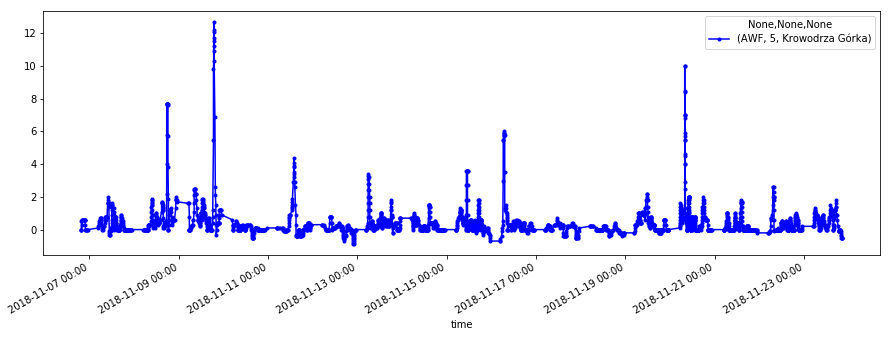

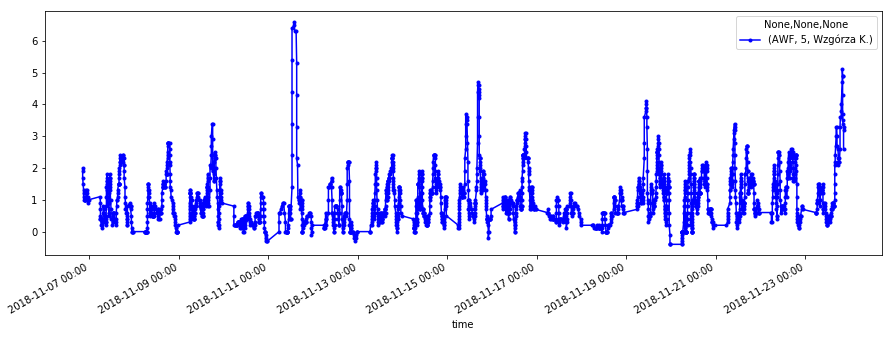

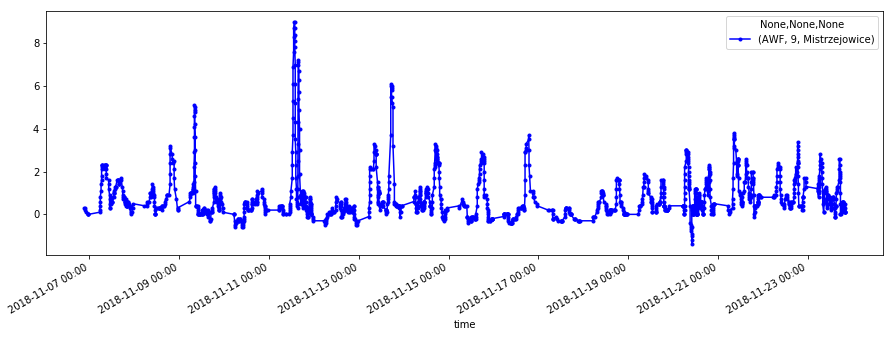

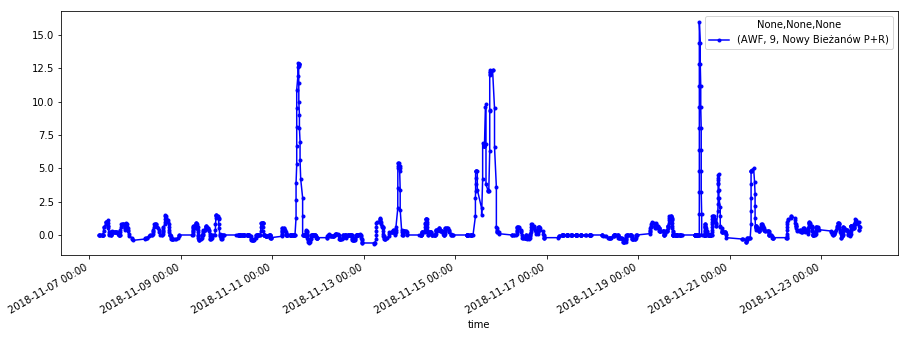

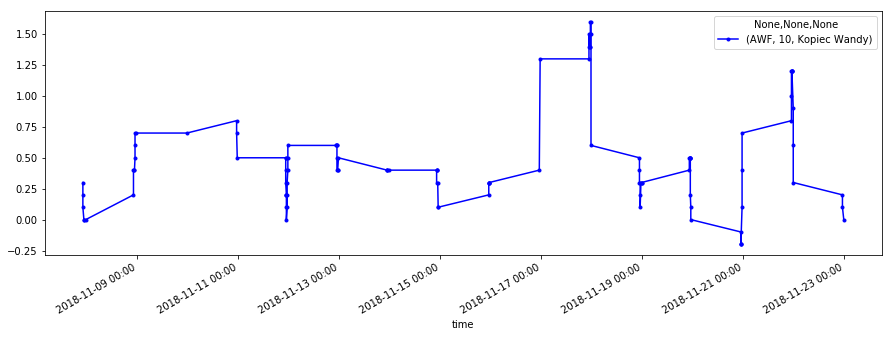

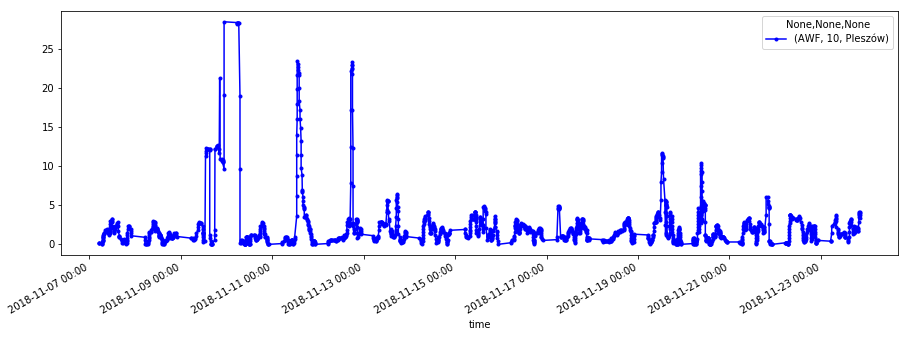

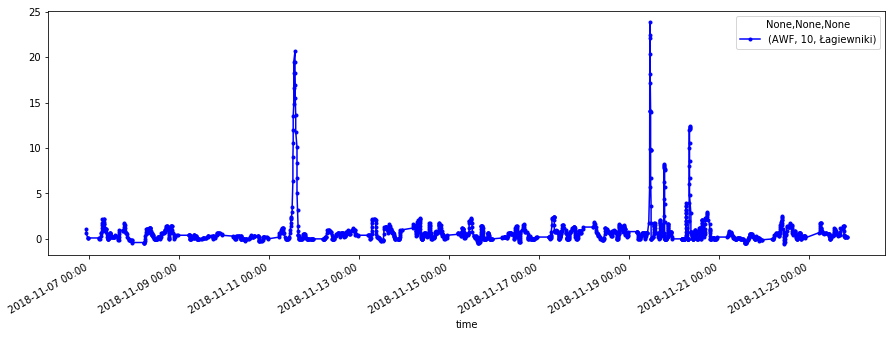

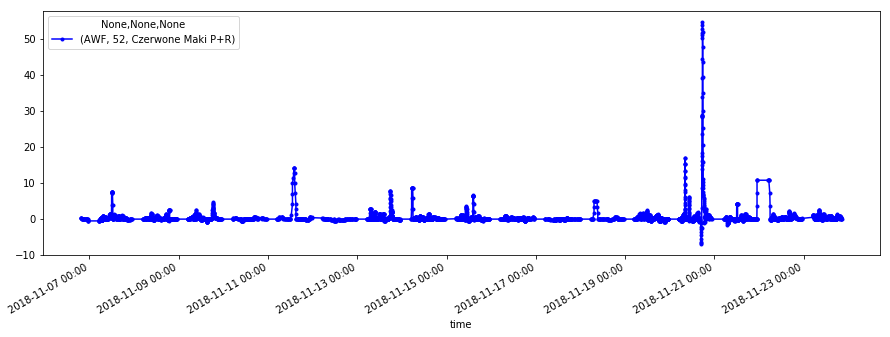

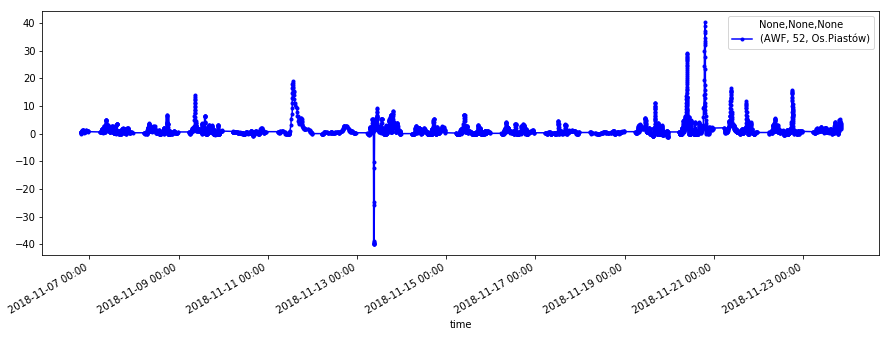

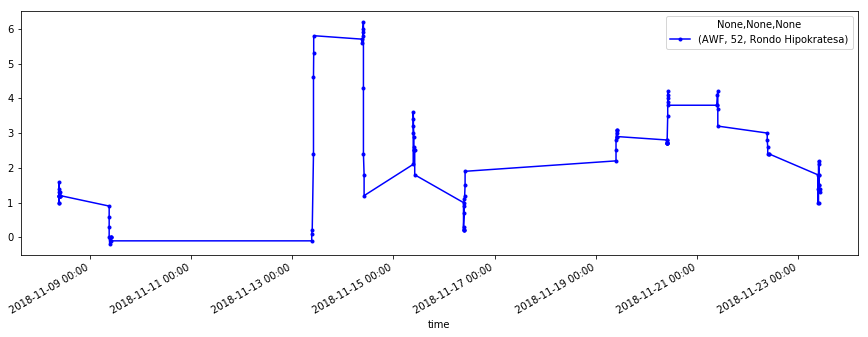

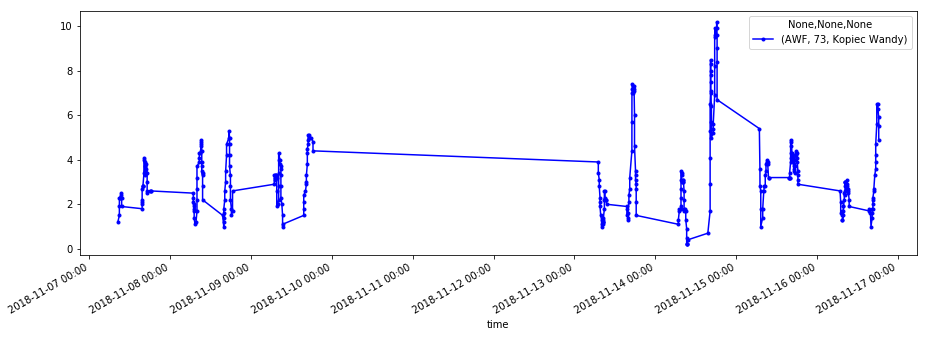

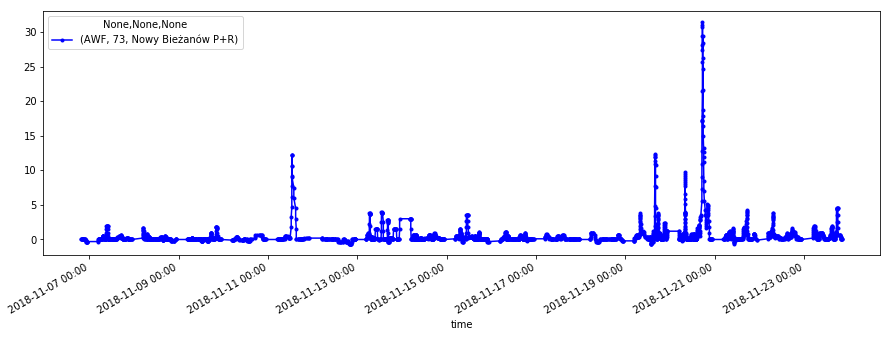

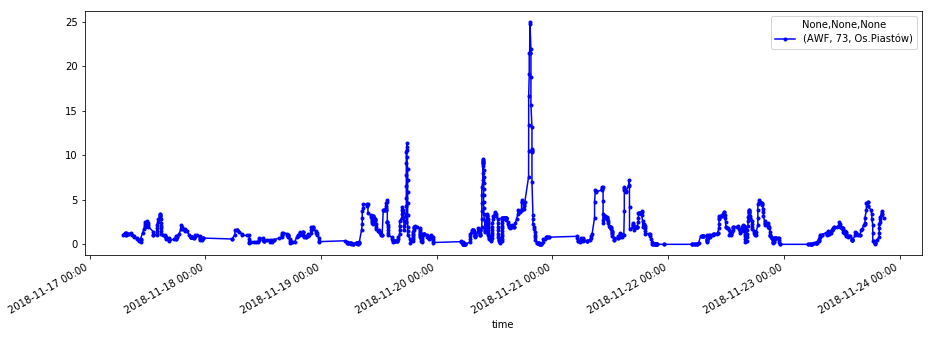

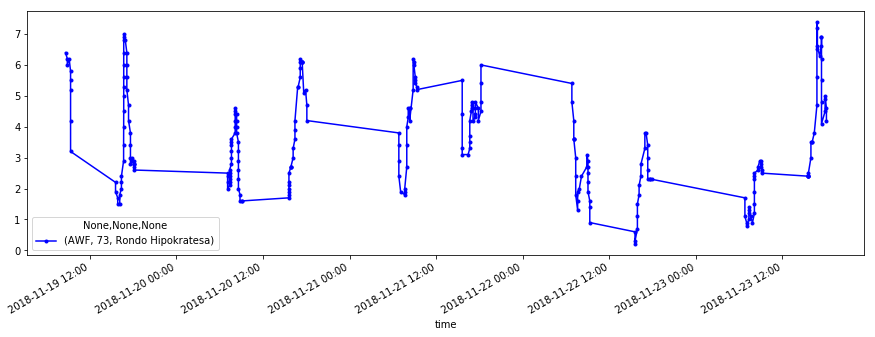

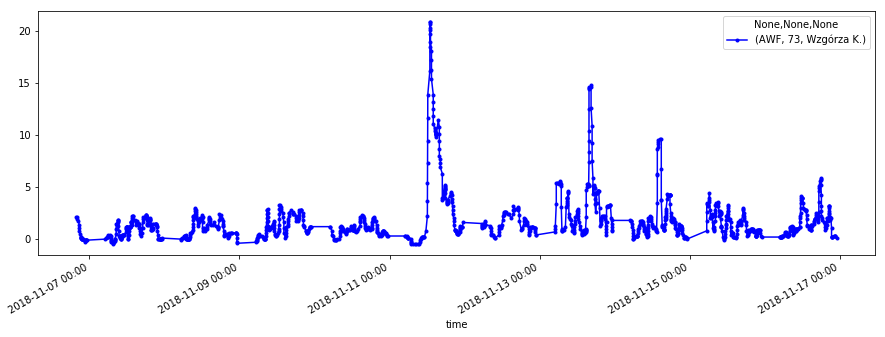

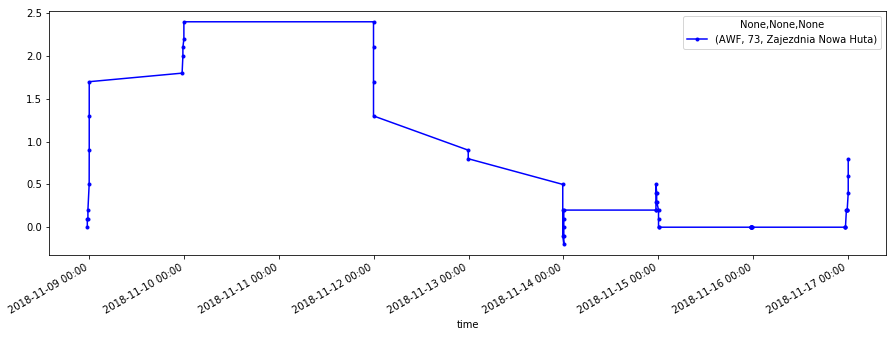

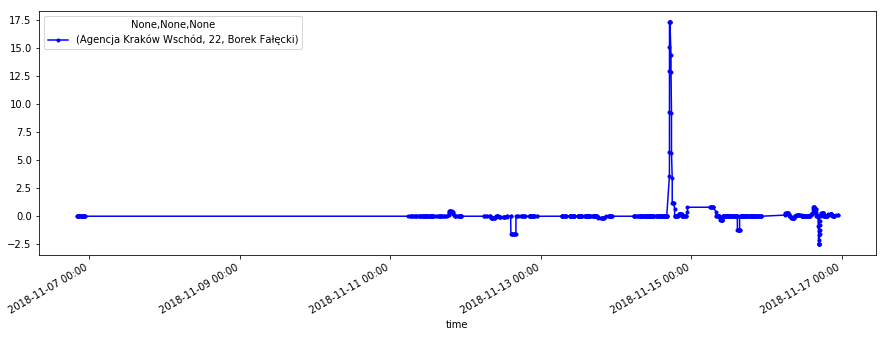

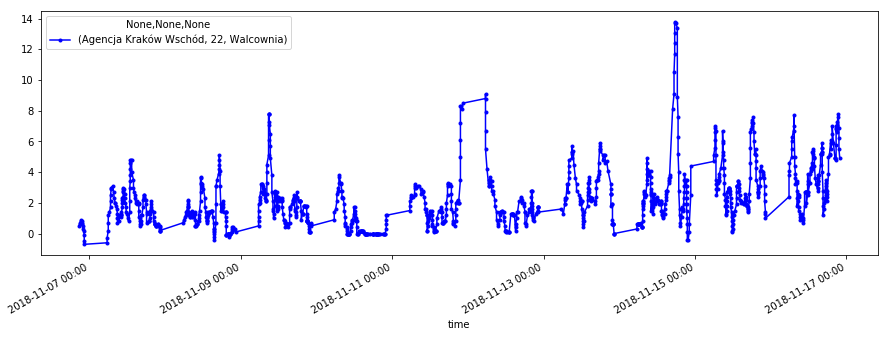

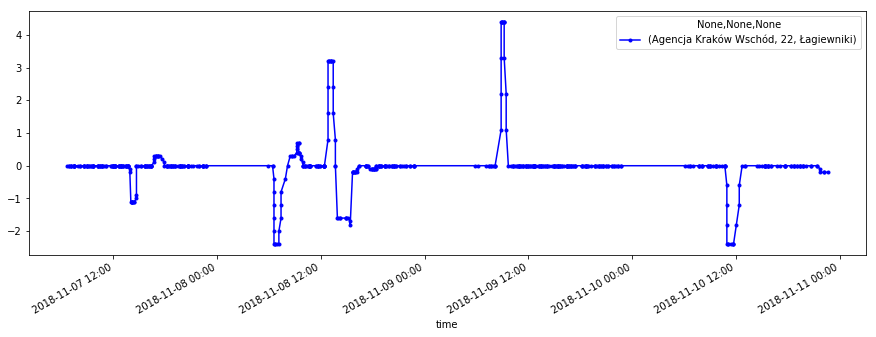

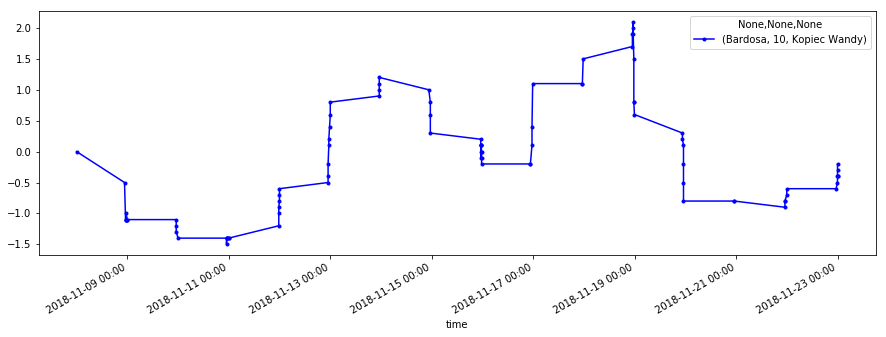

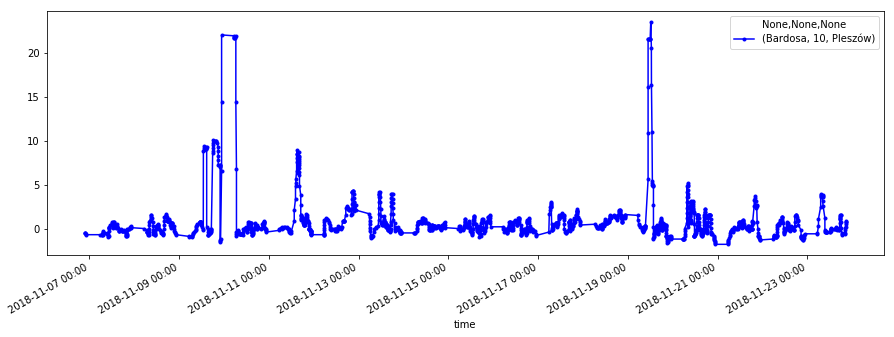

In [16]:
counter = 0
for key, grp in grouped_tram_delays:
    if len(grp['time'].values) > 50:
        grp['rolling_mean_delay'] = grp['delay'].rolling(10).mean()
        fig, ax = plt.subplots(1)
        grp.plot(ax=ax, style='.-', x='time', y='rolling_mean_delay', color='b', label=key)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.show()
        counter = counter + 1;
        if(counter > 20):
            break